# Full flow: preprocess, train and predict
Full flow of all modules implemented. Change `modeltype` to test differens models

In [1]:
from utils.preprocessing import preprocess_videos
from utils.ModelWrapper import ModelWrapper, ModelType
import tensorflow as tf
from utils.predict import predict_multiple
from utils.dot_dict import Dotdict
import wandb

## Init configuration
Change the configuration here

In [3]:
USE_WANDB = True
MODEL_TYPE = ModelType.CNN

### Preprocess

In [3]:
# takes approx 6 min
datasets = {
    "train": ["train"], # Train dataset folders, now points to sample files
    "test": ["test"], # Test dataset fodler, not points to sample files
}

# When processing full directories remove skip_sampling=True because we don't need 50/50 split in the example.
preprocess_videos(datasets, save_dir="data", video_dir="sample", skip_sampling=True)

Processing train datasets
	 Processing train


11it [03:06, 16.91s/it]


Processing test datasets
	 Processing test


10it [03:07, 18.79s/it]


### Train

In [4]:
# Configs
config_defaults = {
    'epochs': 15,
    'regularization': 0.0001,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'optimizer': 'adam',
    'hidden_layer_size': 64,
    'conv_layer_1_size': 16,
    'conv_layer_2_size': 32,
    'conv_layer_3_size': 64,
    'dropout': 0.5,
    "use_augmentation": True,
}

if USE_WANDB:
    wandb.init(config=config_defaults, project="deepfake-efficientnet", entity="dat550")
    config = wandb.config
else:
    config = Dotdict(config_defaults)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dat550 (use `wandb login --relogin` to force relogin)


In [5]:
img_size = 128
data_dir = "./data"

Initialize the model

In [6]:
# Initialize the model
model_file = f'models/{MODEL_TYPE.name}/{wandb.run.name}_model.h5'

# init wrapper
model_wrapper = ModelWrapper(data_dir, img_size, config,model_file=model_file, modeltype=MODEL_TYPE, use_wandb=USE_WANDB)
model_wrapper.model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model_wrapper.model.summary()

Found 71 images belonging to 2 classes.
Found 13 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


2022-05-14 14:01:10.342086: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)       

Train the model

In [7]:
model_wrapper.fit()

3/3 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.5352
Epoch 1: val_loss improved from inf to 0.69766, saving model to models/CNN/azure-oath-37_model.h5
3/3 [==============================] - 3s 705ms/step - loss: 0.6698 - accuracy: 0.5352 - val_loss: 0.6977 - val_accuracy: 0.5385 - _timestamp: 1652529677.0000 - _runtime: 19.0000


Evaluate the model

159/159 [==============================] - 1s 6ms/step
self.test_generator.filenames:  159
preds:  159
conf_matrix: 
 [[140  19]
 [  0   0]]


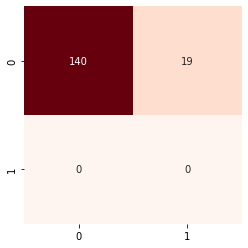

In [8]:
model_to_eval = model_wrapper.model
model_wrapper.evaluate_model(model_to_eval)

### Predict

In [9]:
result = predict_multiple("./sample/test", model_to_eval, frame_rate=1, plot=False)

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


In [10]:
result

,video_name,prediction,predicted_class,real_class
0,acifjvzvpm.mp4,0.671522,FAKE,FAKE
1,acxnxvbsxk.mp4,0.656769,FAKE,FAKE
2,aagfhgtpmv.mp4,0.700379,FAKE,FAKE
3,abqwwspghj.mp4,0.663209,FAKE,FAKE
4,aczrgyricp.mp4,0.678341,FAKE,FAKE
5,acxwigylke.mp4,0.641430,FAKE,FAKE
6,abarnvbtwb.mp4,0.668619,FAKE,REAL
7,acqfdwsrhi.mp4,0.621262,FAKE,FAKE
